In [1]:
# Add the relevant scripts from LArMachineLearningData
# Nice the process so it can run with lots of cores on low priority
import os
os.nice(20)

# Add local paths
import sys
hnlDIR = os.environ['_']
sys.path.append('../pyscript')

# From pyscript Library
from Plotting import *
from Dictionary import *
from HelperFunctions import *
from CutFunctions import *

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import pyhf
from pyhf.contrib.viz import brazil

pyhf.set_backend("numpy")

In [2]:
ifTune = False
ifSave = True
savePath = "../plot_files/06Feb24/"

<h1> Read in HNL Dictionary </h1>

In [3]:
# Load
hnl_dict = np.load('./HNL.npy',allow_pickle='TRUE').item()

In [4]:
hnl_dict

{'200': {'U': 8.944271909999159e-08,
  'sig': array([18.63986556, 15.97359613, 13.06712225, 10.35281193,  7.30221537,
          5.16439574,  4.13151659,  3.36286234,  3.36286234]),
  'sig_flux': array([1.23132667, 1.05858028, 0.89070936, 0.72585306, 0.52270672,
         0.38466216, 0.30198156, 0.24228799, 0.24556319]),
  'sig_stats': array([0.23162136, 0.25020654, 0.27663685, 0.31079272, 0.37006046,
         0.44003806, 0.49197751, 0.5453125 , 0.5453125 ]),
  'bkg': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'bkg_flux': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'bkg_stats': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}}

<h1> Counting Experiment / Sum All Bins</h1>

In [5]:
def error_prop_sum(x_arr):
    sumX = 0
    for x in x_arr:
        sumX += x**2
    sumX = np.sqrt(sumX)
    return sumX

In [6]:
fitU = hnl_dict['200']['U']

sigTot = np.sum(hnl_dict['200']['sig'])
bkgTot = np.sum(hnl_dict['200']['bkg'])

sigTotStatErr = 1 / np.sqrt(sigTot)
bkgTotStatErr = 0

sigTotFluxErr = error_prop_sum(hnl_dict['200']['sig_flux'])
bkgTotFluxErr = error_prop_sum(hnl_dict['200']['bkg_flux'])

In [7]:
print(sigTot)
print(bkgTot)
print(sigTotStatErr)
print(bkgTotStatErr)
print(sigTotFluxErr)
print(bkgTotFluxErr)

81.35724824475643
0.0
0.11086689242367065
0
2.1420476896621508
0.0


<h3> Stats Uncertainty Only </h3>

In [8]:
model_dict = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": [sigTot],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_sig_stat", "type": "shapesys", "data": [sigTotStatErr]}
              ]
            },
            {
              "name": "background",
              "data": [bkgTot],
              "modifiers": [
                {"name": "uncorr_bkg_stat", "type": "shapesys", "data": [bkgTotStatErr]}
              ]
            }
          ]
        }
      ]
    }
    )

print(f'Samples:\n {model_dict.config.samples}')
print(f'Modifiers are:\n {model_dict.config.modifiers}')

Samples:
 ['background', 'signal']
Modifiers are:
 [('mu', 'normfactor'), ('uncorr_bkg_stat', 'shapesys'), ('uncorr_sig_stat', 'shapesys')]


In [9]:
# No DATA --> Data == Background

data = [bkgTot]+model_dict.config.auxdata

In [10]:
#poi_values = np.linspace(0.001, 2, 50)
poi_values = np.linspace(0, 1, 50)

obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(data, 
                                                                                        model_dict, 
                                                                                        poi_values, 
                                                                                        level=0.1, 
                                                                                        return_results=True)

print(f"Upper limit (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

Upper limit (obs): μ = 0.0197
Upper limit (exp): μ = 0.0197



In [11]:
EXP_LIMIT = np.sqrt(exp_limits_single[2])*fitU
LIMIT = np.sqrt(obs_limit_single)*fitU
print(f"Expected limit is " + str(EXP_LIMIT))
print(f"Observed limit is " + str(LIMIT)+ "\n")

sumHistStats = EXP_LIMIT

Expected limit is 1.2559039891042026e-08
Observed limit is 1.2559039890663893e-08



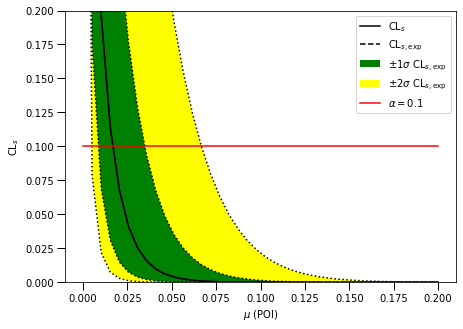

In [12]:
poi_vals = np.linspace(0, 0.2, 40)

results = [
    pyhf.infer.hypotest(
        test_poi, data, model_dict, test_stat="qtilde", return_expected_set=True
    )
    for test_poi in poi_vals
]

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
brazil.plot_results(poi_vals, results, ax=ax, test_size=0.10,)
plt.ylim(0.0,0.2)
fig.show()

In [34]:
cls_obs = np.array([result[0] for result in results]).flatten()
cls_exp = [np.array([result[1][i] for result in results]).flatten() for i in range(5)]

In [37]:
cls_exp

[array([1.00000000e+00, 2.19521313e-01, 1.07238949e-01, 5.97274599e-02,
        3.55964980e-02, 2.21513802e-02, 1.42134060e-02, 9.33387320e-03,
        6.24286392e-03, 4.23887178e-03, 2.91414054e-03, 2.02489089e-03,
        1.42004116e-03, 1.00395351e-03, 7.14889384e-04, 5.12326248e-04,
        3.69284331e-04, 2.67577182e-04, 1.94810316e-04, 1.42455073e-04,
        1.04591899e-04, 7.70799975e-05, 5.70024489e-05, 4.22895253e-05,
        3.14719985e-05, 2.34860434e-05, 1.75742214e-05, 1.31842486e-05,
        9.91396834e-06, 7.47165865e-06, 5.64307256e-06, 4.27066317e-06,
        3.23828036e-06, 2.45999376e-06, 1.87205180e-06, 1.42702818e-06,
        1.08954976e-06, 8.33160496e-07, 6.38060726e-07, 4.89339588e-07,
        3.75797601e-07, 2.88982067e-07, 2.22505268e-07, 1.71531042e-07,
        1.32391418e-07, 1.02299686e-07, 7.91352151e-08, 6.12817040e-08,
        4.75053673e-08, 3.68631006e-08]),
 array([1.00000000e+00, 3.62331801e-01, 2.19157220e-01, 1.44076942e-01,
        9.88628569e-02

<h3>Stats + Uncorrelated Flux Weight Uncertainty</h3>

In [13]:
model_dict = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": [sigTot],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_sig_stat", "type": "shapesys", "data": [sigTotStatErr]},
                {"name": "uncorr_sig_flux", "type": "shapesys", "data": [sigTotFluxErr]}
              ]
            },
            {
              "name": "background",
              "data": [bkgTot],
              "modifiers": [
                {"name": "uncorr_bkg_stat", "type": "shapesys", "data": [bkgTotStatErr]},
                {"name": "uncorr_bkg_flux", "type": "shapesys", "data": [bkgTotFluxErr]}
              ]
            }
          ]
        }
      ]
    }
    )

print(f'Samples:\n {model_dict.config.samples}')
print(f'Modifiers are:\n {model_dict.config.modifiers}')

Samples:
 ['background', 'signal']
Modifiers are:
 [('mu', 'normfactor'), ('uncorr_bkg_flux', 'shapesys'), ('uncorr_bkg_stat', 'shapesys'), ('uncorr_sig_flux', 'shapesys'), ('uncorr_sig_stat', 'shapesys')]


In [14]:
# No DATA --> Data == Background

data = [bkgTot]+model_dict.config.auxdata

In [15]:
#poi_values = np.linspace(0.001, 2, 50)
poi_values = np.linspace(0, 1, 50)

obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(data, 
                                                                                        model_dict, 
                                                                                        poi_values, 
                                                                                        level=0.1, 
                                                                                        return_results=True)

print(f"Upper limit (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

Upper limit (obs): μ = 0.0197
Upper limit (exp): μ = 0.0197



In [16]:
EXP_LIMIT = np.sqrt(exp_limits_single[2])*fitU
LIMIT = np.sqrt(obs_limit_single)*fitU
print(f"Expected limit is " + str(EXP_LIMIT))
print(f"Observed limit is " + str(LIMIT)+ "\n")

sumHistStatsFlux = EXP_LIMIT

Expected limit is 1.2559575810557773e-08
Observed limit is 1.2559581116183777e-08



<h1> Histogram Fit</h1>

In [17]:
sigFit = hnl_dict['200']['sig'].tolist()
bkgFit = hnl_dict['200']['bkg'].tolist()

sigStatErr = hnl_dict['200']['sig_stats'].tolist()
bkgStatErr = hnl_dict['200']['bkg_stats'].tolist()

sigFluxErr = hnl_dict['200']['sig_flux'].tolist()
bkgFluxErr = hnl_dict['200']['bkg_flux'].tolist()

<h3> Stats Uncertainty Only </h3>

In [18]:
model_dict = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": sigFit,
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_sig_stat", "type": "shapesys", "data": sigStatErr}
              ]
            },
            {
              "name": "background",
              "data": bkgFit,
              "modifiers": [
                {"name": "uncorr_bkg_stat", "type": "shapesys", "data": bkgStatErr}
              ]
            }
          ]
        }
      ]
    }
    )

print(f'Samples:\n {model_dict.config.samples}')
print(f'Modifiers are:\n {model_dict.config.modifiers}')

Samples:
 ['background', 'signal']
Modifiers are:
 [('mu', 'normfactor'), ('uncorr_bkg_stat', 'shapesys'), ('uncorr_sig_stat', 'shapesys')]


In [19]:
# No DATA --> Data == Background

data = bkgFit + model_dict.config.auxdata

In [20]:
poi_values = np.linspace(0, 0.1, 50)

obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(data, 
                                                                                        model_dict, 
                                                                                        poi_values, 
                                                                                        level=0.1, 
                                                                                        return_results=True)

print(f"Upper limit (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

Upper limit (obs): μ = 0.0167
Upper limit (exp): μ = 0.0167



In [21]:
EXP_LIMIT = np.sqrt(exp_limits_single[2])*fitU
LIMIT = np.sqrt(obs_limit_single)*fitU
print(f"Expected limit is " + str(EXP_LIMIT))
print(f"Observed limit is " + str(LIMIT)+ "\n")

HistStats = EXP_LIMIT

Expected limit is 1.1544674828214734e-08
Observed limit is 1.1544674828214734e-08



<h3>Stats + Uncorrelated Flux Uncertainty </h3>

In [22]:
model_dict = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": sigFit,
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_sig_stat", "type": "shapesys", "data": sigStatErr},
                {"name": "uncorr_sig_flux", "type": "shapesys", "data": sigFluxErr}
              ]
            },
            {
              "name": "background",
              "data": bkgFit,
              "modifiers": [
                {"name": "uncorr_bkg_stat", "type": "shapesys", "data": bkgStatErr},
                {"name": "uncorr_bkg_flux", "type": "shapesys", "data": bkgFluxErr}
              ]
            }
          ]
        }
      ]
    }
    )

print(f'Samples:\n {model_dict.config.samples}')
print(f'Modifiers are:\n {model_dict.config.modifiers}')

Samples:
 ['background', 'signal']
Modifiers are:
 [('mu', 'normfactor'), ('uncorr_bkg_flux', 'shapesys'), ('uncorr_bkg_stat', 'shapesys'), ('uncorr_sig_flux', 'shapesys'), ('uncorr_sig_stat', 'shapesys')]


In [23]:
# No DATA --> Data == Background

data = bkgFit + model_dict.config.auxdata

In [24]:
poi_values = np.linspace(0, 0.1, 50)

obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(data, 
                                                                                        model_dict, 
                                                                                        poi_values, 
                                                                                        level=0.1, 
                                                                                        return_results=True)

print(f"Upper limit (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

Upper limit (obs): μ = 0.0167
Upper limit (exp): μ = 0.0167



In [25]:
EXP_LIMIT = np.sqrt(exp_limits_single[2])*fitU
LIMIT = np.sqrt(obs_limit_single)*fitU
print(f"Expected limit is " + str(EXP_LIMIT))
print(f"Observed limit is " + str(LIMIT)+ "\n")

HistStatsUncorrFlux = EXP_LIMIT

Expected limit is 1.1547592002967485e-08
Observed limit is 1.1547592002967485e-08



<h3>Quadrature Sum</h3>

In [26]:
sigQuadErr = []
for x, y in zip(sigStatErr, sigFluxErr):
    err = np.sqrt(x**2 + y**2)
    sigQuadErr.append(err)
    
print(sigQuadErr)

[1.252922113825829, 1.0877479099336318, 0.9326795287583625, 0.7895915269062828, 0.6404428636801085, 0.5844642596864936, 0.5772648713064708, 0.5967153393973416, 0.5980526782959725]


In [27]:
model_dict = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": sigFit,
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_sig_stat", "type": "shapesys", "data": sigQuadErr}
              ]
            },
            {
              "name": "background",
              "data": bkgFit,
              "modifiers": [
                {"name": "uncorr_bkg_stat", "type": "shapesys", "data": bkgStatErr}
              ]
            }
          ]
        }
      ]
    }
    )

print(f'Samples:\n {model_dict.config.samples}')
print(f'Modifiers are:\n {model_dict.config.modifiers}')

Samples:
 ['background', 'signal']
Modifiers are:
 [('mu', 'normfactor'), ('uncorr_bkg_stat', 'shapesys'), ('uncorr_sig_stat', 'shapesys')]


In [28]:
# No DATA --> Data == Background

data = bkgFit + model_dict.config.auxdata

In [29]:
poi_values = np.linspace(0, 0.1, 50)

obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(data, 
                                                                                        model_dict, 
                                                                                        poi_values, 
                                                                                        level=0.1, 
                                                                                        return_results=True)

print(f"Upper limit (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

Upper limit (obs): μ = 0.0167
Upper limit (exp): μ = 0.0167



In [30]:
EXP_LIMIT = np.sqrt(exp_limits_single[2])*fitU
LIMIT = np.sqrt(obs_limit_single)*fitU
print(f"Expected limit is " + str(EXP_LIMIT))
print(f"Observed limit is " + str(LIMIT)+ "\n")

HistQuadErr = EXP_LIMIT

Expected limit is 1.1547437325351684e-08
Observed limit is 1.1547437325351684e-08



<h1>Plot</h1>

In [31]:
print(sumHistStats)
print(sumHistStatsFlux)

print(HistStats)
print(HistStatsUncorrFlux)
print(HistQuadErr)

1.2559039891042026e-08
1.2559575810557773e-08
1.1544674828214734e-08
1.1547592002967485e-08
1.1547437325351684e-08


In [32]:
truth_keptall_eff6 = [2.86511499e-07, 2.39422232e-07, 2.03199194e-07, 1.73231133e-07,
       1.53102395e-07, 1.36252088e-07, 1.18427487e-07, 1.08143568e-07,
       9.89825969e-08, 9.11014142e-08, 8.47628114e-08, 7.83813308e-08,
       7.35043555e-08, 6.94843285e-08, 6.63623578e-08, 6.13394286e-08,
       5.92438431e-08, 5.58743660e-08, 5.33525442e-08, 4.98128181e-08,
       4.73009811e-08, 4.48553546e-08, 4.18018862e-08, 3.92112866e-08,
       3.78192449e-08, 3.61950868e-08, 3.43371614e-08, 3.27240829e-08,
       3.24631805e-08, 3.10644104e-08, 3.05293818e-08, 2.87910113e-08,
       2.78364688e-08, 2.56644802e-08, 2.51186433e-08, 2.45098885e-08,
       2.38659244e-08, 2.25502542e-08, 2.21790510e-08, 2.15899712e-08,
       2.12649093e-08, 2.06274291e-08, 2.03773313e-08, 1.96340364e-08,
       1.85347912e-08, 1.82909252e-08, 1.75781442e-08, 1.67300003e-08,
       1.66046784e-08, 1.58717646e-08, 1.55195813e-08, 1.53911843e-08,
       1.47224741e-08, 1.46323197e-08, 1.40726902e-08, 1.37266731e-08,
       1.33494438e-08, 1.29057977e-08, 1.25740591e-08, 1.23369035e-08,
       1.19901593e-08, 1.19686495e-08, 1.18047484e-08, 1.15259397e-08,
       1.12301811e-08, 1.05196994e-08, 1.04957734e-08, 1.03552231e-08,
       9.94526855e-09, 9.89544275e-09, 9.76438603e-09, 9.55189442e-09,
       9.21343579e-09, 9.09712427e-09, 8.78050771e-09, 8.71313480e-09,
       8.50868242e-09, 8.52141288e-09, 8.18778714e-09, 8.16115990e-09,
       7.88183352e-09, 7.70329186e-09, 7.60536280e-09, 7.35131640e-09,
       7.11484856e-09, 7.10275520e-09, 7.09866671e-09, 6.95697066e-09,
       6.81591255e-09, 6.64591304e-09, 6.43498398e-09, 6.38653479e-09,
       6.29605251e-09, 6.27369506e-09, 6.06667565e-09, 5.86700176e-09,
       5.82369552e-09, 5.70600062e-09, 5.73800975e-09, 5.51139033e-09,
       5.52711316e-09, 5.42822272e-09, 5.25412806e-09, 5.23241107e-09,
       5.11108543e-09, 2.86511499e-07, 2.39422232e-07, 2.03199194e-07,
       1.73231133e-07, 1.53102395e-07, 1.36252088e-07, 1.18427487e-07,
       1.08143568e-07, 9.89825969e-08, 9.11014142e-08, 8.47628114e-08,
       7.83813308e-08, 7.35043555e-08, 6.94843285e-08, 6.63623578e-08,
       6.13394286e-08, 5.92438431e-08, 5.58743660e-08, 5.33525442e-08,
       4.98128181e-08, 4.73009811e-08, 4.48553546e-08, 4.18018862e-08,
       3.92112866e-08, 3.78192449e-08, 3.61950868e-08, 3.43371614e-08,
       3.27240829e-08, 3.24631805e-08, 3.10644104e-08, 3.05293818e-08,
       2.87910113e-08, 2.78364688e-08, 2.56644802e-08, 2.51186433e-08,
       2.45098885e-08, 2.38659244e-08, 2.25502542e-08, 2.21790510e-08,
       2.15899712e-08, 2.12649093e-08, 2.06274291e-08, 2.03773313e-08,
       1.96340364e-08, 1.85347912e-08, 1.82909252e-08, 1.75781442e-08,
       1.67300003e-08, 1.66046784e-08, 1.58717646e-08, 1.55195813e-08,
       1.53911843e-08, 1.47224741e-08, 1.46323197e-08, 1.40726902e-08,
       1.37266731e-08, 1.33494438e-08, 1.29057977e-08, 1.25740591e-08,
       1.23369035e-08, 1.19901593e-08, 1.19686495e-08, 1.18047484e-08,
       1.15259397e-08, 1.12301811e-08, 1.05196994e-08, 1.04957734e-08,
       1.03552231e-08, 9.94526855e-09, 9.89544275e-09, 9.76438603e-09,
       9.55189442e-09, 9.21343579e-09, 9.09712427e-09, 8.78050771e-09,
       8.71313480e-09, 8.50868242e-09, 8.52141288e-09, 8.18778714e-09,
       8.16115990e-09, 7.88183352e-09, 7.70329186e-09, 7.60536280e-09,
       7.35131640e-09, 7.11484856e-09, 7.10275520e-09, 7.09866671e-09,
       6.95697066e-09, 6.81591255e-09, 6.64591304e-09, 6.43498398e-09,
       6.38653479e-09, 6.29605251e-09, 6.27369506e-09, 6.06667565e-09,
       5.86700176e-09, 5.82369552e-09, 5.70600062e-09, 5.73800975e-09,
       5.51139033e-09, 5.52711316e-09, 5.42822272e-09, 5.25412806e-09,
       5.23241107e-09, 5.11108543e-09]

m_array_nupi0 = [140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244]

NameError: name 'M' is not defined

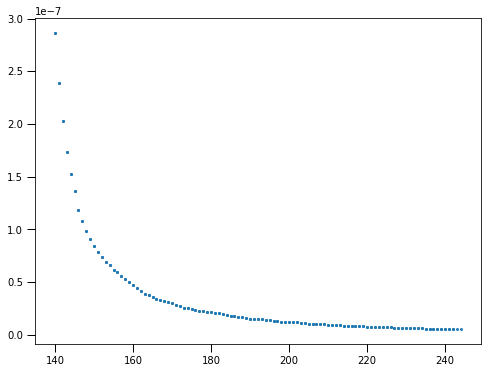

In [33]:
fig, ax1 = plt.subplots(1,1, figsize=(8,6))
xlimmin = 140
xlimmax = 244
#-------------------------------------------------------------------


#-------------------------------------------------------------------
dfx = m_array_nupi0
dfy = truth_keptall_eff6
plt.scatter(dfx[:-2], dfy[:-2], lw = 2, ls = '-', s=1, label='Truth Selection \nBetween Bucket Cut = 8 ns\nReco x Selection Eff=50% \n90% CL ')
#-------------------------------------------------------------------
ax1.scatter(M , sumHistStats, marker='x', s = 300,color = 'green', label = "Sum Bin Stat Uncrt Only")
ax1.scatter(M , sumHistStatsFlux, marker='x', s = 300,color = 'orange', label = "Sum Bin Stat + Flux Uncrt")

ax1.scatter(M , HistStats, marker='+', s = 300,color = 'green', label = "Hist Stat Uncrt Only")
ax1.scatter(M , HistStatsUncorrFlux, marker='+', s = 300,color = 'orange', label = "Hist Stat + Uncorr Flux Uncrt")
ax1.scatter(M , HistStatsUncorrFlux, marker='+', s = 300,color = 'blue', label = "Hist Quadrature Sum Uncrt")


#-------------------------------------------------------------------
plt.xlim(180, 220)
plt.ylim(5e-9, 5e-8)
ax1.set_yscale('log')
plt.legend(loc="upper left", fontsize =14)

ax1.set_xlabel( "HNL Mass [MeV]", fontsize =14)
ax1.set_ylabel("|U$_{\mu4}$|$^2$", fontsize =14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#-------------------------------------------------------------------
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("sensitivity_test.png"), dpi=200)
plt.show()